In [1]:
import yaml 

import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

import lightgbm as lgb

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

from aux_functions import fit_line, invert_regr

In [2]:
# %load_ext memory_profiler
# %load_ext line_profiler
%load_ext autoreload
%autoreload 2

## Data & parameters

In [3]:
df_ER_train = pd.read_csv('csv_data/df_ER.csv', index_col='Unnamed: 0')
df_NR_train = pd.read_csv('csv_data/df_NR.csv', index_col='Unnamed: 0')
df_train = pd.concat([df_ER_train, df_NR_train])

In [4]:
df_ER_train_old = pd.read_csv('csv_data/archive/df_ER_old.csv', index_col='Unnamed: 0')
df_NR_train_old = pd.read_csv('csv_data/archive/df_NR_old.csv', index_col='Unnamed: 0')
df_train_old = pd.concat([df_ER_train_old, df_NR_train_old])

In [5]:
df_public = pd.read_csv('csv_data/df_public_test.csv', index_col='Unnamed: 0')
df_private = pd.read_csv('csv_data/df_private_test.csv', index_col='Unnamed: 0')

In [6]:
with open('../region_params.yml') as f:
    region_params = yaml.load(f, Loader=yaml.FullLoader)

## Calibration curve

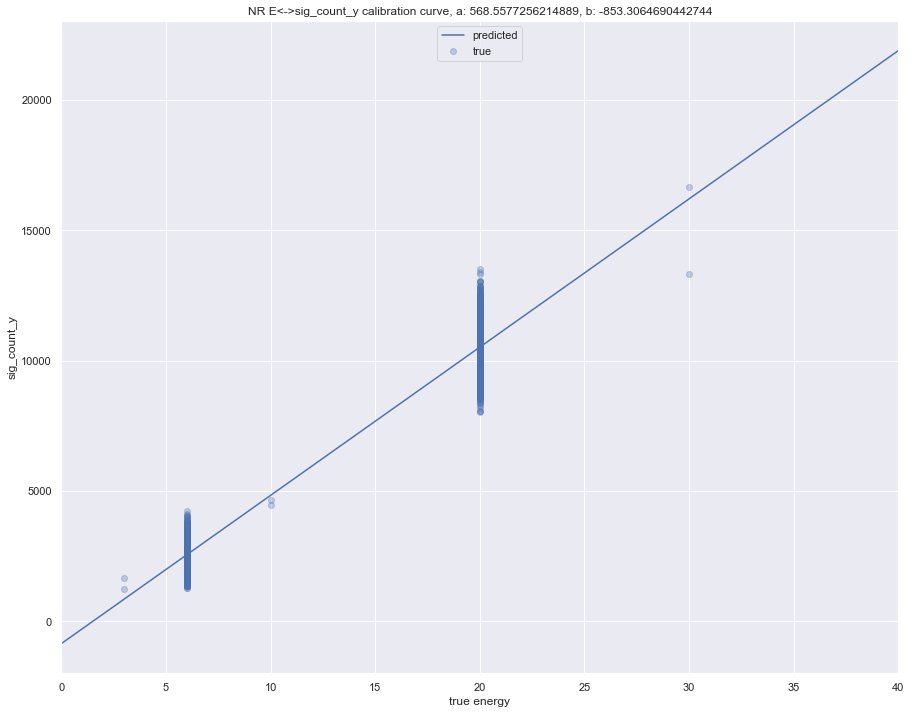

In [7]:
a, b = fit_line(df_train)

In [8]:
df_public['E_regr'] = invert_regr(a, b, df_public['sig_count_y'])
df_private['E_regr'] = invert_regr(a, b, df_private['sig_count_y'])
#
df_public['E_regr_x'] = invert_regr(a, b, df_public['sig_count_x'])
df_private['E_regr_x'] = invert_regr(a, b, df_private['sig_count_x'])

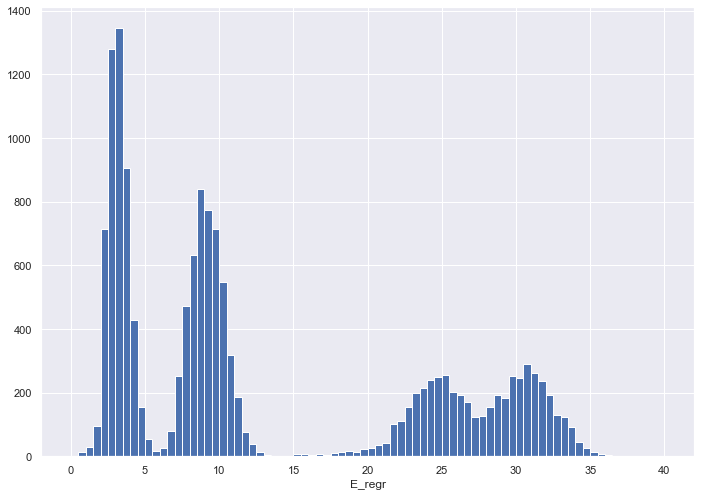

In [9]:
plt.hist(df_private['E_regr'], bins=80, range=(0., 40.))
plt.xlabel('E_regr')
plt.show()

## High energies

### train HE (aka wiggly) classifier

In [10]:
df_train_HE = df_train.query('(event_energy == 20 and event_class != "ER") or (event_energy == 30 and event_class != "NR")')

In [11]:
HE_vars = region_params['HE']['vars']
HE_vars

['chi2_pvalue_x', 'chi2_pvalue_y', 'abs_dmu_x', 'abs_dmu_y']

In [12]:
df_train_HE['abs_dmu_x'] = np.abs(df_train_HE.mu_x - 288)
df_train_HE['abs_dmu_y'] = np.abs(df_train_HE.mu_y - 288)
#
df_public['abs_dmu_x'] = np.abs(df_public.mu_x - 288)
df_public['abs_dmu_y'] = np.abs(df_public.mu_y - 288)
df_private['abs_dmu_x'] = np.abs(df_private.mu_x - 288)
df_private['abs_dmu_y'] = np.abs(df_private.mu_y - 288)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
X_HE = df_train_HE[HE_vars]
y_HE = df_train_HE.event_energy == 30

In [14]:
HE_clf_params = region_params['HE']['model_params']
HE_clf_params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'metric': 'binary_logloss',
 'max_depth': 4,
 'learning_rate': 0.1,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'verbose': -1,
 'seed': 777}

In [15]:
lgb_HE_train = lgb.Dataset(X_HE, y_HE, free_raw_data=False)
HE_clf = lgb.train(
                HE_clf_params,
                lgb_HE_train,
                num_boost_round=1000,
               )

### test on private domain samples

In [16]:
df_train_NR_private_domain = df_train.query('event_class == "NR" and event_energy == 30')
df_train_NR_private_domain['abs_dmu_x'] = np.abs(df_train_NR_private_domain.mu_x - 288)
df_train_NR_private_domain['abs_dmu_y'] = np.abs(df_train_NR_private_domain.mu_y - 288)
df_train_NR_private_domain


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,N_bkgr_only_x,N_bkgr_only_y,N_error_bkgr_only_x,N_error_bkgr_only_y,N_error_x,N_error_y,N_x,N_y,bkgr_count_x,bkgr_count_y,...,tolerance_bkgr_only_x,tolerance_bkgr_only_y,tolerance_x,tolerance_y,up_bkgr_only_x,up_bkgr_only_y,up_x,up_y,abs_dmu_x,abs_dmu_y
295,1.459969e+06,1.460003e+06,1208.291808,1208.305754,1208.614805,1208.652759,1.460749e+06,1.460841e+06,1.445084e+06,1.444186e+06,...,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0,0.246724,0.547204
3336,1.458436e+06,1.458583e+06,1207.657104,1207.718161,1207.901871,1207.952399,1.459027e+06,1.459149e+06,1.445968e+06,1.445814e+06,...,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0,0.695644,0.393188


In [17]:
df_train_ER_private_domain = df_train.query('event_class == "ER" and event_energy == 20')
df_train_ER_private_domain['abs_dmu_x'] = np.abs(df_train_ER_private_domain.mu_x - 288)
df_train_ER_private_domain['abs_dmu_y'] = np.abs(df_train_ER_private_domain.mu_y - 288)
df_train_ER_private_domain


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,N_bkgr_only_x,N_bkgr_only_y,N_error_bkgr_only_x,N_error_bkgr_only_y,N_error_x,N_error_y,N_x,N_y,bkgr_count_x,bkgr_count_y,...,tolerance_bkgr_only_x,tolerance_bkgr_only_y,tolerance_x,tolerance_y,up_bkgr_only_x,up_bkgr_only_y,up_x,up_y,abs_dmu_x,abs_dmu_y
88,1.459844e+06,1.459781e+06,1208.240082,1208.213869,1208.377341,1208.416193,1.460170e+06,1.460270e+06,1.447035e+06,1.447318e+06,...,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0,25.808461,16.185264
1935,1.455492e+06,1.455429e+06,1206.437822,1206.411432,1206.541136,1206.582449,1.455741e+06,1.455841e+06,1.444382e+06,1.445163e+06,...,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0,10.068181,14.733023


In [18]:
HE_clf.predict(df_train_NR_private_domain[HE_vars])

array([2.68381577e-07, 2.26515819e-07])

In [19]:
HE_clf.predict(df_train_ER_private_domain[HE_vars])

array([0.9999999 , 0.99999986])

### label public/private

In [20]:
HE_clf_thr = region_params['HE']['model_thr']
HE_clf_thr

0.5

In [21]:
HE_left, HE_right = region_params['HE']['left'], region_params['HE']['right']
HE_left, HE_right

(14.0, inf)

In [22]:
df_public_HE = df_public.query(f'E_regr >= {HE_left} and E_regr < {HE_right}')
df_private_HE = df_private.query(f'E_regr >= {HE_left} and E_regr < {HE_right}')

In [23]:
public_HE_pred = pd.Series(data=HE_clf.predict(df_public_HE[HE_vars]), index=df_public_HE.index)
private_HE_pred = pd.Series(HE_clf.predict(df_private_HE[HE_vars]), index=df_private_HE.index)

In [24]:
public_HE_pred_classes = public_HE_pred > HE_clf_thr # if wiggly, then assign label 1 (ER)
public_HE_pred_energies = 20*(public_HE_pred_classes) + 30*(~public_HE_pred_classes) # if wiggly, then assign label 1 (ER)
public_HE_image_names = df_public_HE.image_name
assert len(public_HE_pred_classes) == len(public_HE_pred_energies) and len(public_HE_pred_classes) == len(public_HE_image_names)

In [25]:
private_HE_pred_classes = private_HE_pred > HE_clf_thr # if wiggly, then assign label 1 (ER)
private_HE_pred_energies = 20*(private_HE_pred > HE_clf_thr) + 30*(private_HE_pred <= HE_clf_thr) # if wiggly, then assign label 1 (ER)
private_HE_image_names = df_private_HE.image_name
assert len(private_HE_pred_classes) == len(private_HE_pred_energies) and len(private_HE_pred_classes) == len(private_HE_image_names)

In [26]:
np.unique(public_HE_pred_classes, return_counts=True)

(array([False,  True]), array([259, 269]))

In [27]:
np.unique(private_HE_pred_classes, return_counts=True)

(array([False,  True]), array([2527, 2493]))

## Middle energies

In [28]:
MID_clf_thr = region_params['MID']['model_thr']
MID_clf_thr

5.25

In [29]:
MID_left, MID_right = region_params['MID']['left'], region_params['MID']['right']
MID_left, MID_right

(6.0, 14.0)

In [30]:
MID_discriminator = region_params['MID']['model_params']['discriminator']

### test on private domain samples

In [31]:
df_train_MID_private_domain = df_train.query('event_class == "ER" and event_energy == 6')
df_train_MID_private_domain

,N_bkgr_only_x,N_bkgr_only_y,N_error_bkgr_only_x,N_error_bkgr_only_y,N_error_x,N_error_y,N_x,N_y,bkgr_count_x,bkgr_count_y,...,sigma_x,sigma_y,tolerance_bkgr_only_x,tolerance_bkgr_only_y,tolerance_x,tolerance_y,up_bkgr_only_x,up_bkgr_only_y,up_x,up_y
2950,1.450287e+06,1.450417e+06,1204.278505,1204.332587,1204.317146,1204.363644,1.450380e+06,1.450492e+06,1.445151e+06,1.446360e+06,...,5.614171,4.526541,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0


In [32]:
~(df_train_MID_private_domain[MID_discriminator] > MID_clf_thr)

2950    True
Name: sigma_y, dtype: bool

In [33]:
df_train_MID_private_domain = df_train.query('event_class == "NR" and event_energy == 10')
df_train_MID_private_domain

,N_bkgr_only_x,N_bkgr_only_y,N_error_bkgr_only_x,N_error_bkgr_only_y,N_error_x,N_error_y,N_x,N_y,bkgr_count_x,bkgr_count_y,...,sigma_x,sigma_y,tolerance_bkgr_only_x,tolerance_bkgr_only_y,tolerance_x,tolerance_y,up_bkgr_only_x,up_bkgr_only_y,up_x,up_y
2586,1.452346e+06,1.452454e+06,1205.133359,1205.178074,1205.161122,1205.204675,1.452413e+06,1.452518e+06,1.448509e+06,1.447863e+06,...,4.516990,6.314966,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0
3573,1.450520e+06,1.450634e+06,1204.375220,1204.422529,1204.408523,1204.451319,1.450600e+06,1.450703e+06,1.445654e+06,1.446229e+06,...,5.799134,5.542084,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0


In [34]:
~(df_train_MID_private_domain[MID_discriminator] > MID_clf_thr)

2586    False
3573    False
Name: sigma_y, dtype: bool

### label public/private

In [35]:
df_public_MID = df_public.query(f'E_regr >= {MID_left} and E_regr < {MID_right}')
df_private_MID = df_private.query(f'E_regr >= {MID_left} and E_regr < {MID_right}')

In [36]:
public_MID_pred = df_public_MID[MID_discriminator] > MID_clf_thr 
private_MID_pred = df_private_MID[MID_discriminator] > MID_clf_thr 

In [37]:
public_MID_pred_classes = ~public_MID_pred # if higher sigma, then assign label 0 (NR)
public_MID_pred_energies = 10*(public_MID_pred_classes) + 6*(~public_MID_pred_classes) # 10 keV if class=1 (ER), 6 if class=0 (NR)
public_MID_image_names = df_public_MID.image_name
assert len(public_MID_pred_classes) == len(public_MID_pred_energies) and len(public_MID_pred_classes) == len(public_MID_image_names)

In [38]:
private_MID_pred_classes = ~private_MID_pred # if higher sigma, then assign label 0 (NR)
private_MID_pred_energies = 6*(private_MID_pred_classes) + 10*(~private_MID_pred_classes) # 6 keV if class=1 (ER), 10 if class=0 (NR)
private_MID_image_names = df_private_MID.image_name
assert len(private_MID_pred_classes) == len(private_MID_pred_energies) and len(private_MID_pred_classes) == len(private_MID_image_names)

In [39]:
np.unique(public_MID_pred_classes, return_counts=True)

(array([False,  True]), array([152, 202]))

In [40]:
np.unique(private_MID_pred_classes, return_counts=True)

(array([False,  True]), array([2515, 2457]))

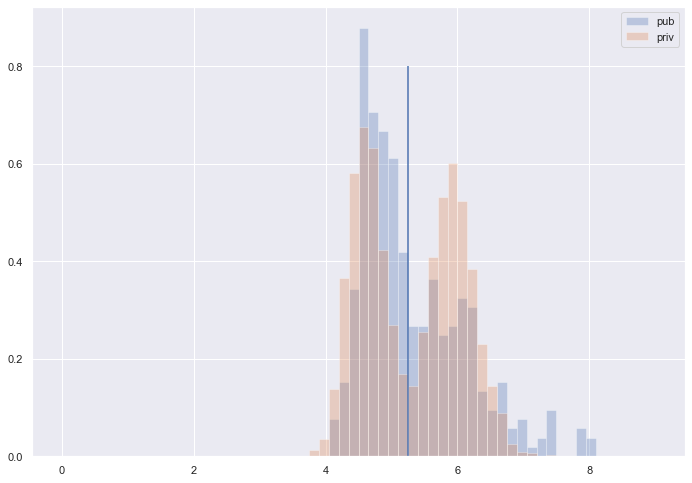

In [41]:
plt.hist(df_public_MID[MID_discriminator], density=True, range=(0, 9), bins=60, label='pub', alpha=0.3)
plt.hist(df_private_MID[MID_discriminator], density=True, range=(0, 9), bins=60, label='priv', alpha=0.3)
plt.vlines(MID_clf_thr, 0, 0.8)
plt.legend()
plt.show()

## Low energies

In [42]:
LOW_clf_thr = region_params['LOW']['model_thr']
LOW_clf_thr

4.95

In [43]:
LOW_left, LOW_right = region_params['LOW']['left'], region_params['LOW']['right']
LOW_left, LOW_right

(-inf, 6.0)

In [44]:
LOW_discriminator = region_params['LOW']['model_params']['discriminator']

### test on private domain samples

In [45]:
df_train_LOW_private_domain = df_train.query('event_class == "ER" and event_energy == 1')
df_train_LOW_private_domain

,N_bkgr_only_x,N_bkgr_only_y,N_error_bkgr_only_x,N_error_bkgr_only_y,N_error_x,N_error_y,N_x,N_y,bkgr_count_x,bkgr_count_y,...,sigma_x,sigma_y,tolerance_bkgr_only_x,tolerance_bkgr_only_y,tolerance_x,tolerance_y,up_bkgr_only_x,up_bkgr_only_y,up_x,up_y
359,1.447592e+06,1.447736e+06,1203.159109,1203.219067,1203.160393,1203.220225,1.447594e+06,1.447739e+06,1.446518e+06,1.447056e+06,...,6.941650,3.504310,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0
3691,1.446428e+06,1.446556e+06,1202.675187,1202.728370,1202.676877,1227.635416,1.446432e+06,1.446580e+06,1.445113e+06,1.444020e+06,...,7.712159,21.405731,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0
4162,1.446001e+06,1.446115e+06,1202.497698,1202.545393,1202.502829,1202.546046,1.446013e+06,1.446117e+06,1.444618e+06,1.445758e+06,...,3.301077,1.815743,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0


In [46]:
~(df_train_LOW_private_domain[LOW_discriminator] > LOW_clf_thr)

359      True
3691    False
4162     True
Name: sigma_y, dtype: bool

In [47]:
df_train_LOW_private_domain = df_train.query('event_class == "NR" and event_energy == 3')
df_train_LOW_private_domain

,N_bkgr_only_x,N_bkgr_only_y,N_error_bkgr_only_x,N_error_bkgr_only_y,N_error_x,N_error_y,N_x,N_y,bkgr_count_x,bkgr_count_y,...,sigma_x,sigma_y,tolerance_bkgr_only_x,tolerance_bkgr_only_y,tolerance_x,tolerance_y,up_bkgr_only_x,up_bkgr_only_y,up_x,up_y
5442,1.447775e+06,1.447894e+06,1203.235059,1203.284864,1203.239136,1203.287391,1.447784e+06,1.447901e+06,1.445835e+06,1.446237e+06,...,7.118009,8.109052,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0
5684,1.447392e+06,1.447488e+06,1203.075886,1203.116033,1203.079212,1203.117934,1.447400e+06,1.447493e+06,1.446642e+06,1.446266e+06,...,1.581173,6.233059,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0


In [48]:
~(df_train_LOW_private_domain[LOW_discriminator] > LOW_clf_thr)

5442    False
5684    False
Name: sigma_y, dtype: bool

### label public/private

In [49]:
df_public_LOW = df_public.query(f'E_regr >= {LOW_left} and E_regr < {LOW_right}')
df_private_LOW = df_private.query(f'E_regr >= {LOW_left} and E_regr < {LOW_right}')

In [50]:
public_LOW_pred = df_public_LOW[LOW_discriminator] > LOW_clf_thr 
private_LOW_pred = df_private_LOW[LOW_discriminator] > LOW_clf_thr 

In [51]:
public_LOW_pred_classes = ~public_LOW_pred # if higher sigma, then assign label 0 (NR)
public_LOW_pred_energies = 3*(public_LOW_pred_classes) + 1*(~public_LOW_pred_classes) # 10 keV if class=1 (ER), 6 if class=0 (NR)
public_LOW_image_names = df_public_LOW.image_name
assert len(public_LOW_pred_classes) == len(public_LOW_pred_energies) and len(public_LOW_pred_classes) == len(public_LOW_image_names)

In [52]:
private_LOW_pred_classes = ~private_LOW_pred # if higher sigma, then assign label 0 (NR)
private_LOW_pred_energies = 1*(private_LOW_pred_classes) + 3*(~private_LOW_pred_classes) # 6 keV if class=1 (ER), 10 if class=0 (NR)
private_LOW_image_names = df_private_LOW.image_name
assert len(private_LOW_pred_classes) == len(private_LOW_pred_energies) and len(private_LOW_pred_classes) == len(private_LOW_image_names)

In [53]:
np.unique(public_LOW_pred_classes, return_counts=True)

(array([False,  True]), array([323, 297]))

In [54]:
np.unique(private_LOW_pred_classes, return_counts=True)

(array([False,  True]), array([2884, 2182]))

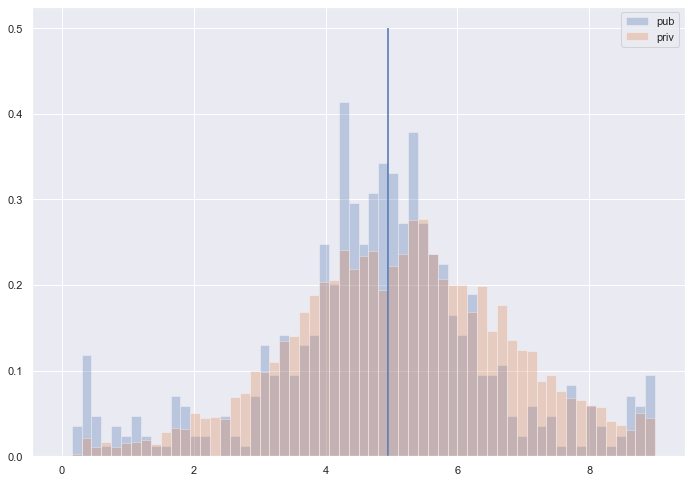

In [55]:
plt.hist(df_public_LOW[LOW_discriminator], density=True, range=(0, 9), bins=60, label='pub', alpha=0.3)
plt.hist(df_private_LOW[LOW_discriminator], density=True, range=(0, 9), bins=60, label='priv', alpha=0.3)
plt.vlines(LOW_clf_thr, 0, 0.5)
plt.legend()
plt.show()

## Force labels

### zone 26

In [56]:
idx_to_force_in_zone26 = df_private[HE_clf.predict(df_private[HE_vars]) < 0.5].query('E_regr > 14 and E_regr < 26').index
idx_to_force_in_zone26

Int64Index([   44,    75,  1034,  3449,  4426,  5353,  6591,  9483,  9983,
            11263, 12123, 12393, 12490, 12556, 13366, 14008, 14881],
           dtype='int64')

In [57]:
idx_to_force_in_zone26 = idx_to_force_in_zone26[[0, 3, 5, 11, 16]]
private_HE_pred_energies[idx_to_force_in_zone26] = 20
private_HE_pred_classes[idx_to_force_in_zone26] = 1

### low wiggly

In [58]:
idx_to_force_low_wiggly = df_private[HE_clf.predict(df_private[HE_vars]) > 0.5].query('E_regr < 1.5 and E_regr_x > 9').index
idx_to_force_low_wiggly

Int64Index([  631,   825,   883,  1173,  1266,  1496,  1729,  2215,  2436,
             2708,  2906,  2935,  3112,  3197,  3400,  4254,  4690,  5013,
             5084,  5912,  6091,  6568,  6660,  6911,  7365,  7612,  7862,
             8016,  8862,  9244,  9400,  9505,  9733, 10193, 10601, 10633,
            10689, 10939, 12428, 12693, 13245, 13352, 13723, 14049, 14449],
           dtype='int64')

In [59]:
private_LOW_pred_energies[idx_to_force_low_wiggly] = 20
private_LOW_pred_classes[idx_to_force_low_wiggly] = 1

### high wiggly

In [60]:
idx_to_force_high_wiggly = df_private.query('E_regr > 14 and E_regr_x < 20').index
idx_to_force_high_wiggly

Int64Index([   66,    77,   222,   411,   467,   583,   590,   651,   821,
              893,
            ...
            14597, 14627, 14656, 14698, 14710, 14821, 14851, 14971, 14982,
            15021],
           dtype='int64', length=207)

In [61]:
private_HE_pred_classes[idx_to_force_high_wiggly] = 1

## Generate submission

In [62]:
submission = pd.DataFrame(columns=['id', 'classification_predictions', 'regression_predictions'])

In [63]:
image_id = pd.concat([public_LOW_image_names, public_MID_image_names, public_HE_image_names, private_LOW_image_names, private_MID_image_names, private_HE_image_names], ignore_index=True)
clf_pred = pd.concat([public_LOW_pred_classes, public_MID_pred_classes, public_HE_pred_classes, private_LOW_pred_classes, private_MID_pred_classes, private_HE_pred_classes], ignore_index=True)
regr_pred = pd.concat([public_LOW_pred_energies, public_MID_pred_energies, public_HE_pred_energies, private_LOW_pred_energies, private_MID_pred_energies, private_HE_pred_energies], ignore_index=True)

In [64]:
submission_id, submission_clf_pred, submission_regr_pred = list(zip(*sorted(zip(image_id, clf_pred, regr_pred))))

In [65]:
image_id[777], clf_pred[777], regr_pred[777]

('5ce7fd109ab579460dedfa64279c2bb2c51e0b13', True, 10)

In [66]:
submission.query(f'id == "{image_id[777]}"')

,id,classification_predictions,regression_predictions


In [67]:
submission['id'] = submission_id
submission['classification_predictions'] = submission_clf_pred
submission['regression_predictions'] = submission_regr_pred

In [68]:
submission.to_csv('pipeline_Oleg.csv', index=False, header=True)